In [2]:
import os
import cv2
import sys
import cc3d
import torch
import random
import shutil
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy import misc
from libtiff import TIFF
from einops import rearrange
from scipy.cluster.vq import kmeans,vq,whiten
from skimage.morphology import skeletonize,thin


def read_tiff_stack(path):
    if os.path.isdir(path):
        images = [np.array(Image.open(os.path.join(path, p))) for p in sorted(os.listdir(path))]
        return np.array(images)
    else:
        img = Image.open(path)
        images = []
        for i in range(img.n_frames):
            img.seek(i)
            slice = np.array(img)
            images.append(slice)
        return np.array(images)


def thined_component(stack, vol):    
    labels = cc3d.connected_components(stack)
    shapes = labels.shape
    labels = labels.flatten()
    mark = [0] * (labels.max() + 1)
    for i in labels:
        mark[i] += 1
    for k in range(len(labels)):
        if mark[labels[k]] < vol:
            labels[k] = 0
    labels[labels > 0] = 255

    return labels.reshape(shapes)


def sekeleton_batch(base, target, device, connectives=10):
    for pth in tqdm(os.listdir(base)):
        labels = read_tiff_stack(base + pth)
        
        # Clear junks，removing 3D connectives with voxel number 10 by default.
        labels = thined_component(labels, connectives) # 
        
        # Do skeleton
        skeleton = skeletonize(labels)
        
        # Do dilation
        x =  torch.Tensor(skeleton.reshape(1,1,*skeleton.shape)).to(device)
        p1 = torch.nn.functional.max_pool3d(x, (3, 1, 1), 1, (1, 0, 0))
        p2 = torch.nn.functional.max_pool3d(x, (1, 3, 1), 1, (0, 1, 0))
        p3 = torch.nn.functional.max_pool3d(x, (1, 1, 3), 1, (0, 0, 1))
        min_pool_x = torch.min(torch.min(p1, p2), p3)
        x = torch.max(torch.max(p1, p2), p3)
        x = np.array(x.cpu()[0][0]).astype(np.uint8)

        x[x > 0] = 255
        x[x <= 0] = 0

        tifffile.imsave(target + pth, x.astype(np.uint8))
    
    print('Done.')

## Training cube preparation steps

1. Open the 3D image stack with ImageJ and perform a whole-brain-wide view. It is recommended to adjust B&C (Ctrl+Shift+C) to complete a more detailed observation.
2. Use the multi-point tool to label some centroids to ensure that only axons or no axons are included in a certain range.
3. Press M to bring up the Result window >> File >> Save as .csv

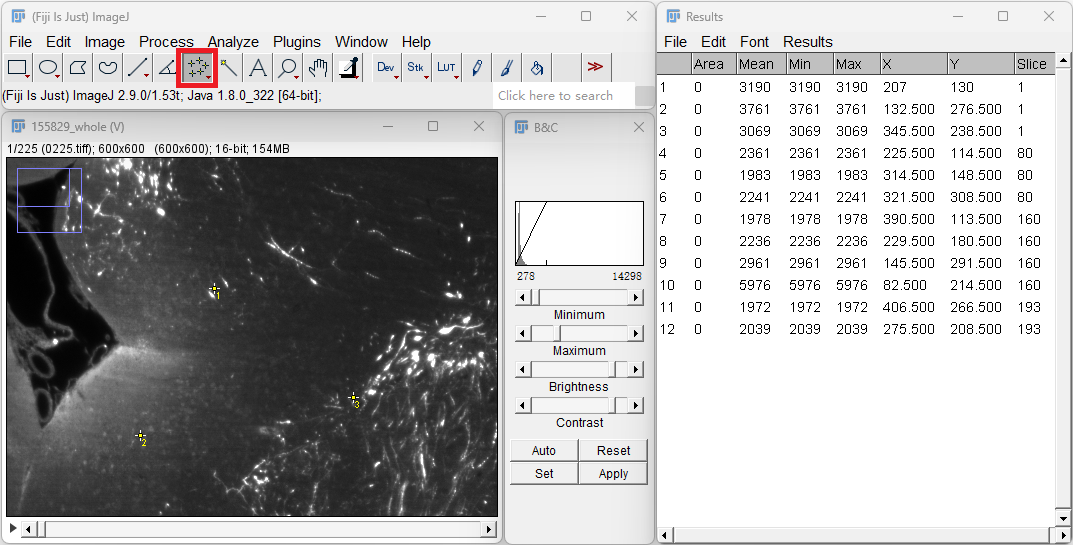


## Run the cube cutting script:

In [15]:
# Original whole brain image stack storage location
whole_brain_root = "./data/brain-example/"

# The path where the cut cube is stored
crop_target = "./data/cropped-cubes/"

# Path to the center point csv file
center_point_csv_file = "./data/example.csv"

# The starting number of the cube to prevent overwriting when the data is added to the same path
CODE = "1000"

command = 'python ./scripts/tiffcropper.py  -s {} -t {} -c {} -i {} --label'.format(whole_brain_root, 
                                                                                    crop_target, 
                                                                                    center_point_csv_file, 
                                                                                    CODE)
os.system(command)

## Processing of the select axon and artefact cubes

1. Open the automatically generated volume and label file.
2. Adjust the B&C to label file >> Apply.
3. set the appropriate threshold value >> Apply >> Save.

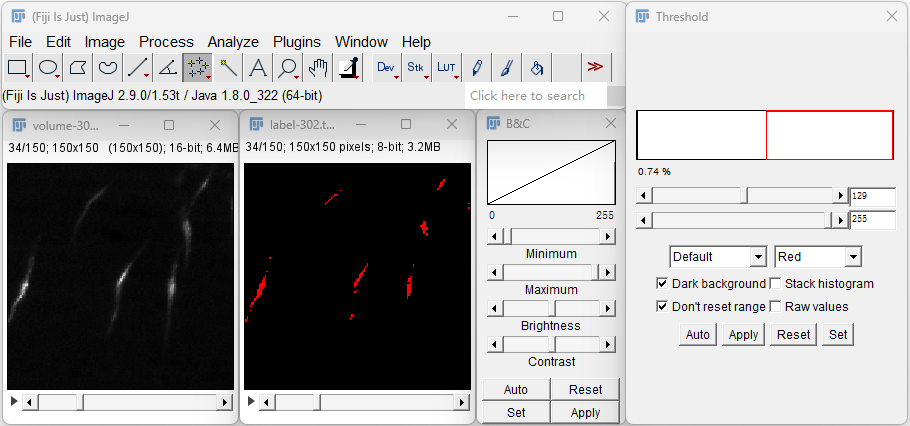

## Get skeletonized concentrate label

In [16]:
# Label path
base = "./data/label-examples/Rough-label/"

# Skeletonized concentrate label storage path
target = "./data/label-examples/Fine-label/"

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
connectives = 10

sekeleton_batch(base, target, device, connectives)

## Whole brain segmentation

1. Open your whole brain image in ImageJ to confirm the size.
2. Edit "./Axonal-semantic-segmenter/segpoints.ini", replace x,y and slides in the order displayed by ImageJ.

In [17]:
# Because the whole brain segmentation takes longer, it is more recommended to execute the following command in the console.

batch_size = '2'
gpu_ids = '0'
section = 'example3'
exp = 'exp-name'
overlap = 20
process = 2

# Pre-trained model path
pre_trained = './Axonal-semantic-segmenter/example_checkpoint.pth'

command = "python ./Axonal-semantic-segmenter/eval.py --batch_size {} "\
            "--gpu_ids {} --net genericunet --val_type segment --section {}"\
            " --exp {} --overlap {} --output_nc 2 --process {} --pre_trained {}".format(batch_size,
                                                                                       gpu_ids,
                                                                                       section,
                                                                                       exp,
                                                                                       overlap,
                                                                                       process,
                                                                                       pre_trained)
print(command)
os.system(command)